In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Настройка стиля графиков
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [14]:
def load_ablation_data(base_path="../artifacts/ablation"):
    all_data = []
    
    # Ищем все папки в директории абляций
    experiments = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    
    for exp_name in sorted(experiments):
        csv_path = os.path.join(base_path, exp_name, "stats.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            # Добавляем колонку с названием эксперимента для легенды
            df['Experiment'] = exp_name
            # Сглаживание для графиков (Moving Average)
            df['smoothed_length'] = df['episode_length'].rolling(window=50, min_periods=5).mean()
            df['smoothed_reward'] = df['total_reward'].rolling(window=50, min_periods=5).mean()
            all_data.append(df)
            print(f"Loaded: {exp_name} ({len(df)} episodes)")
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

df_all = load_ablation_data()

Loaded: 0_baseline (1256 episodes)
Loaded: 1_only_norm (1206 episodes)


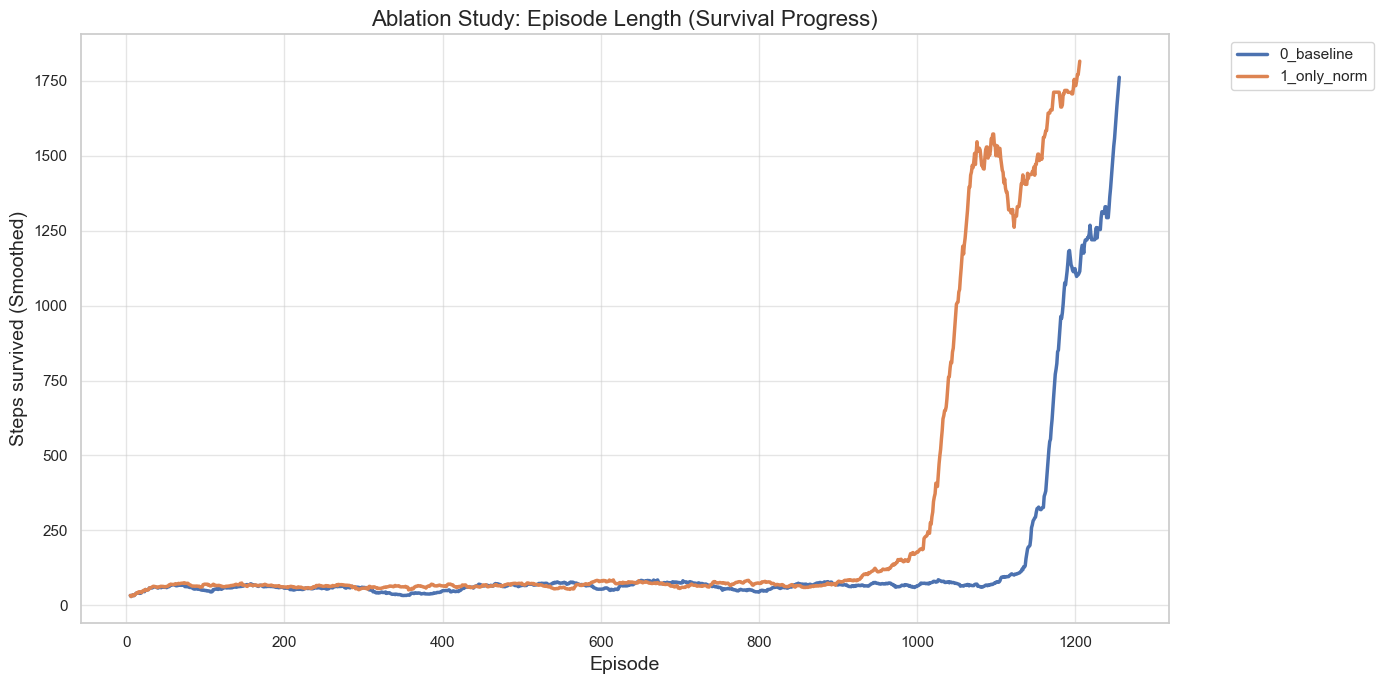

In [15]:
if not df_all.empty:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_all, x="episode", y="smoothed_length", hue="Experiment", linewidth=2.5)
    
    plt.title("Ablation Study: Episode Length (Survival Progress)", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Steps survived (Smoothed)", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No data found. Run run_ablation.sh first!")

/var/folders/y3/19gt23yd4zg9k93kytyfqj2w0000gn/T/ipykernel_14721/2148008646.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_stats, x="episode_length", y="Experiment", palette="viridis")


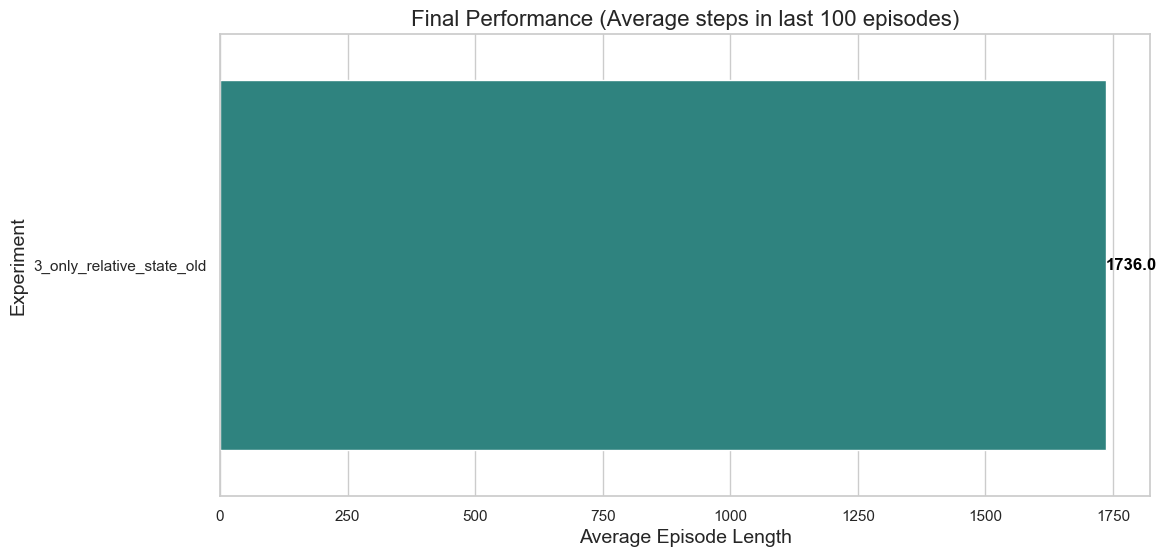

In [4]:
# Берем последние 100 эпизодов для каждого эксперимента
last_100 = df_all[df_all['episode'] > (df_all['episode'].max() - 100)]
final_stats = last_100.groupby('Experiment')['episode_length'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=final_stats, x="episode_length", y="Experiment", palette="viridis")

plt.title("Final Performance (Average steps in last 100 episodes)", fontsize=16)
plt.xlabel("Average Episode Length", fontsize=14)
plt.ylabel("Experiment", fontsize=14)

# Добавляем значения на бары
for i, v in enumerate(final_stats['episode_length']):
    plt.text(v + 0.5, i, f"{v:.1f}", color='black', va='center', fontweight='bold')

plt.show()

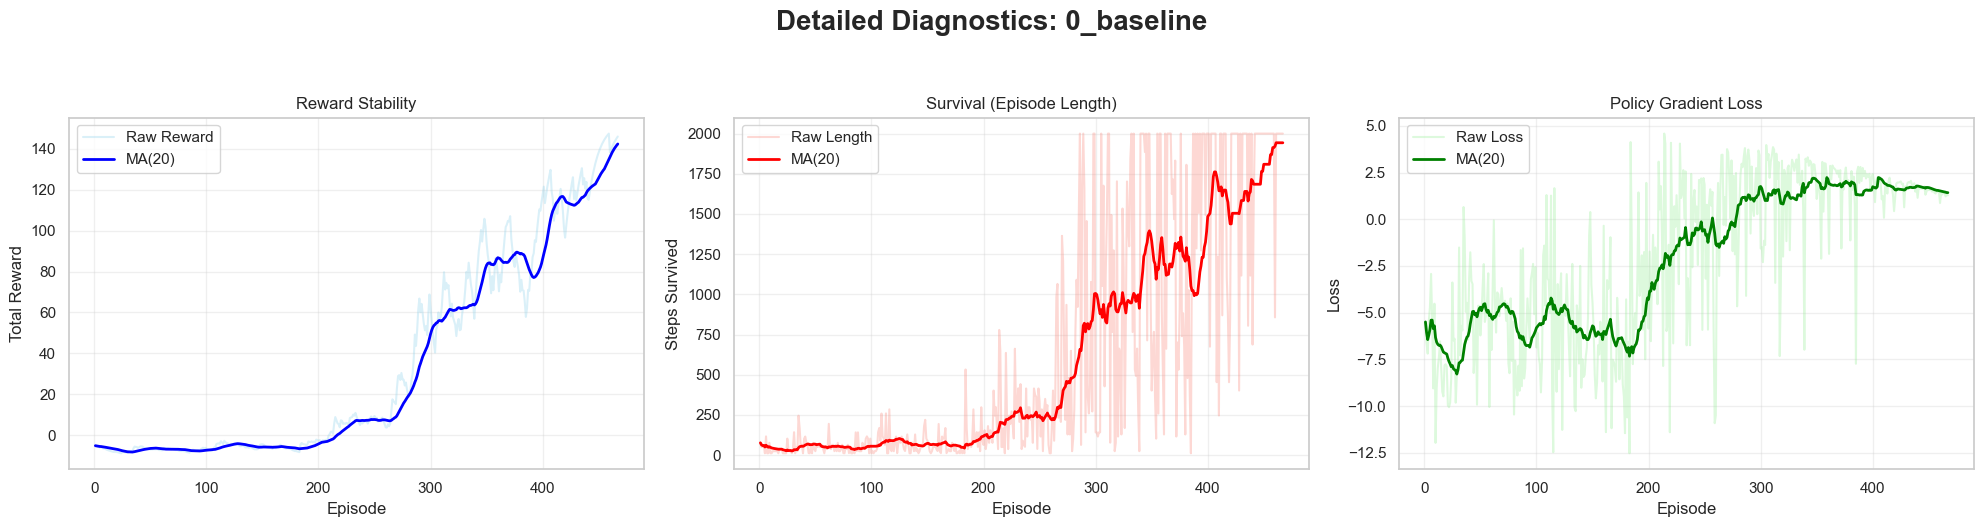

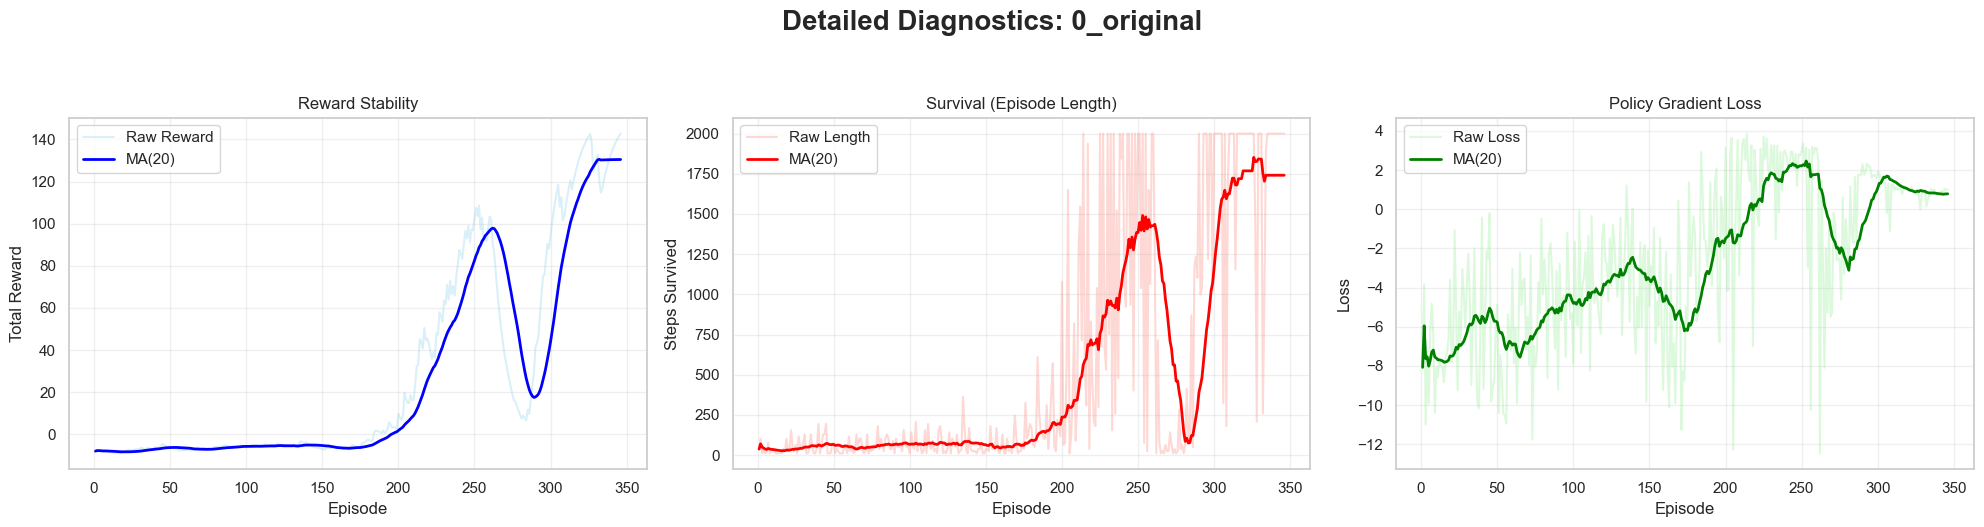

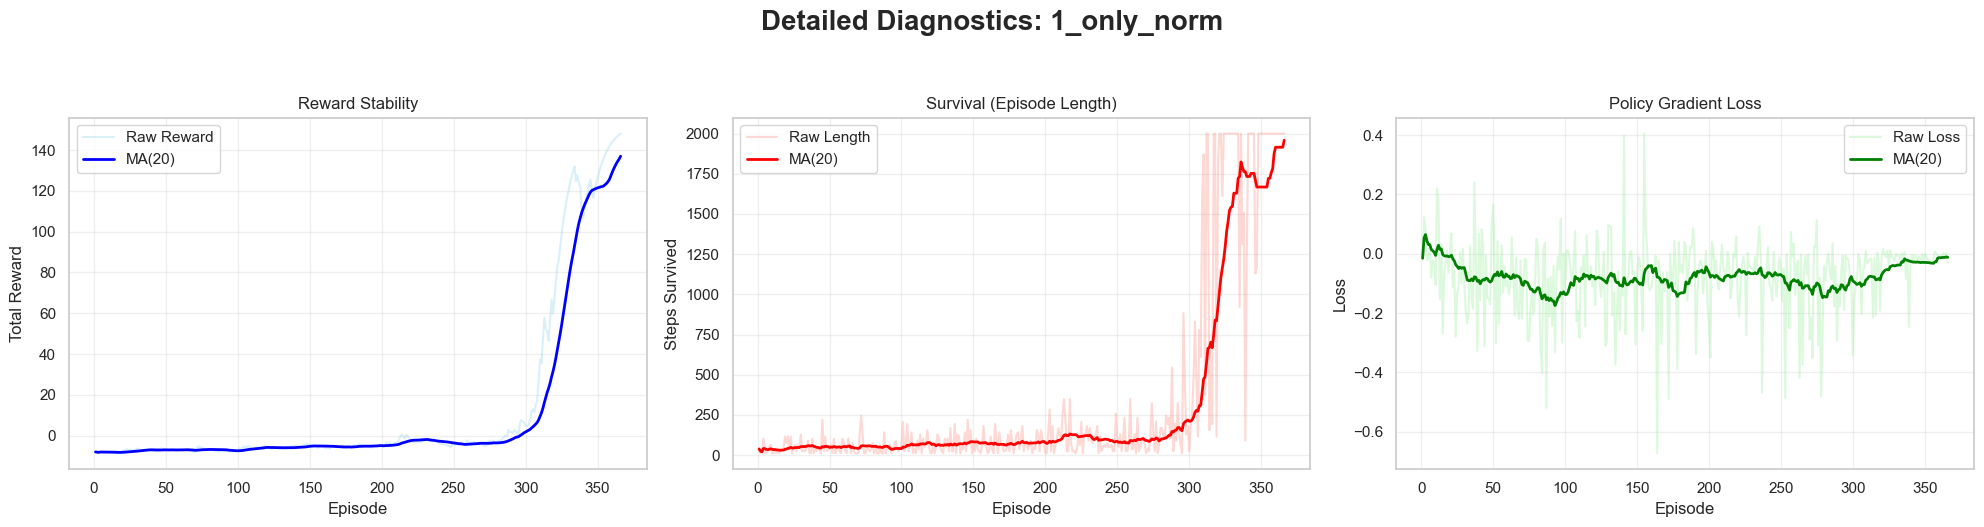

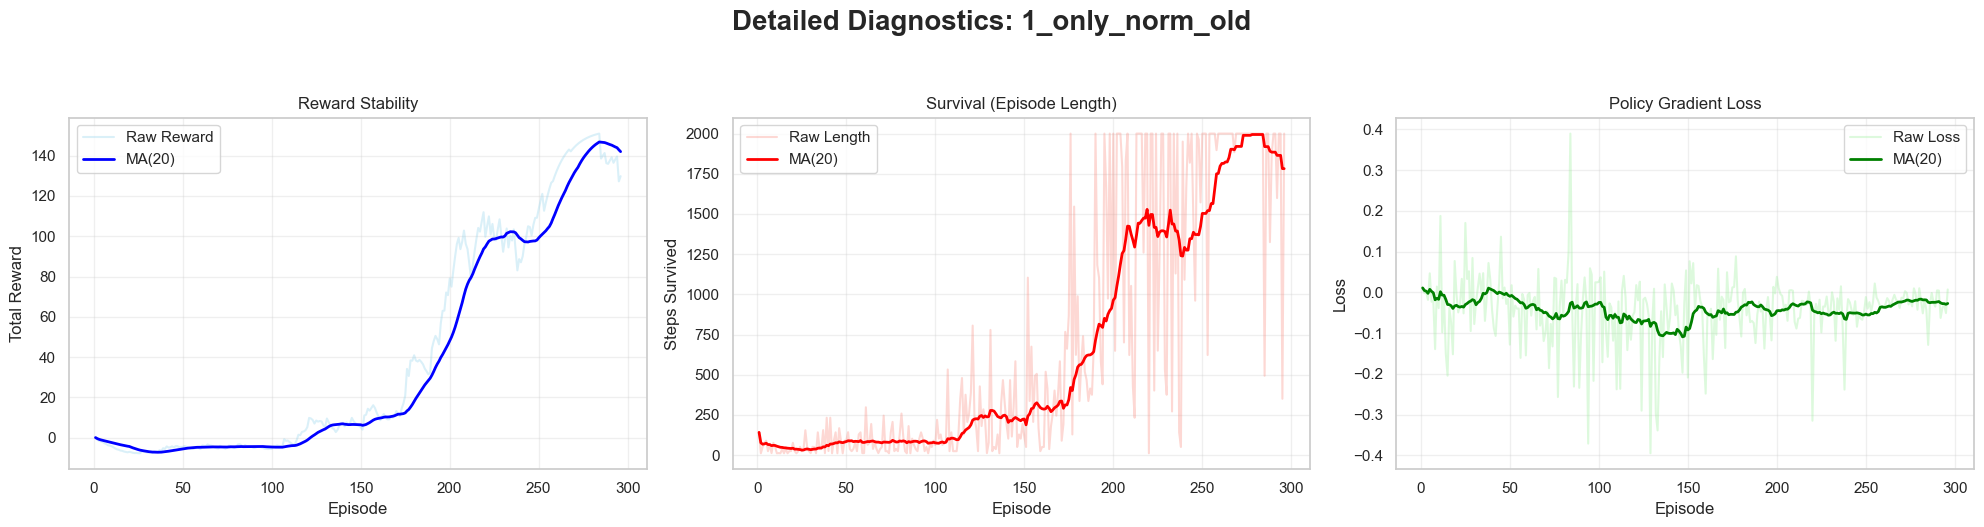

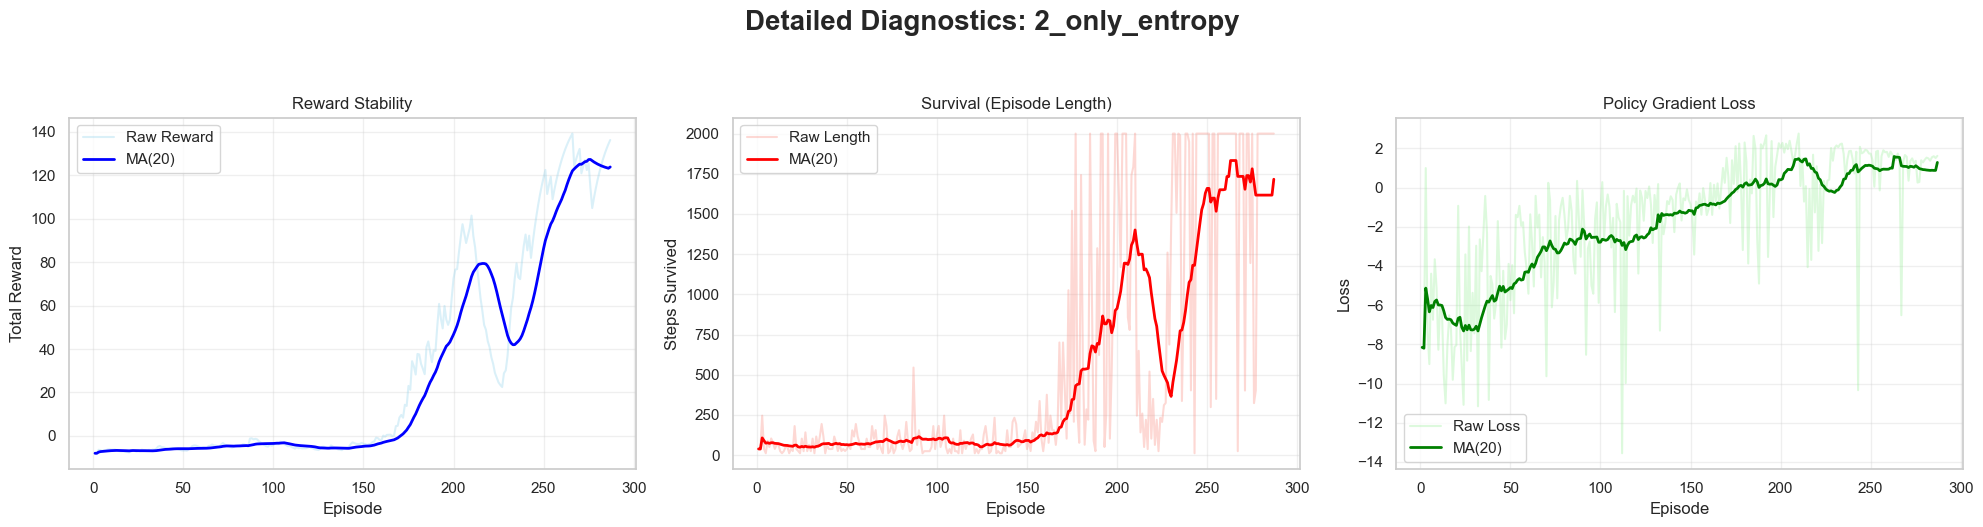

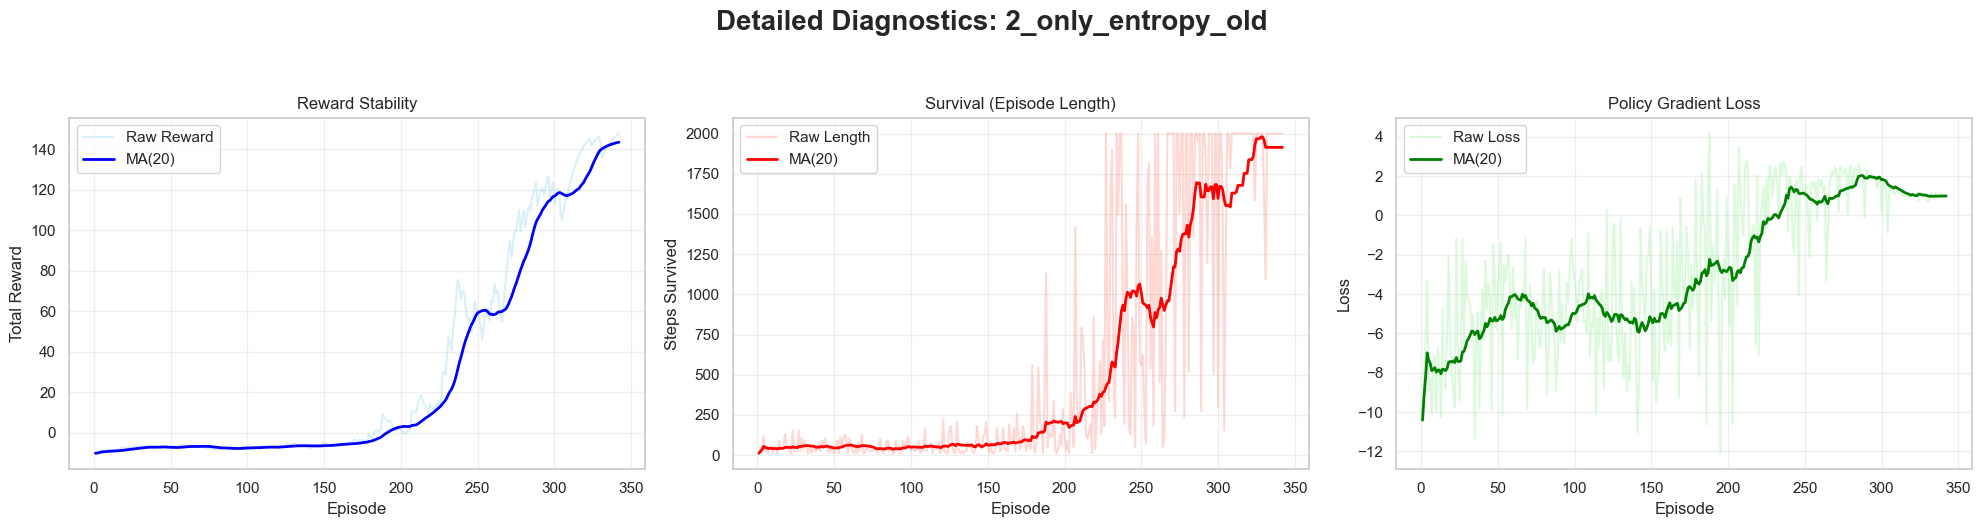

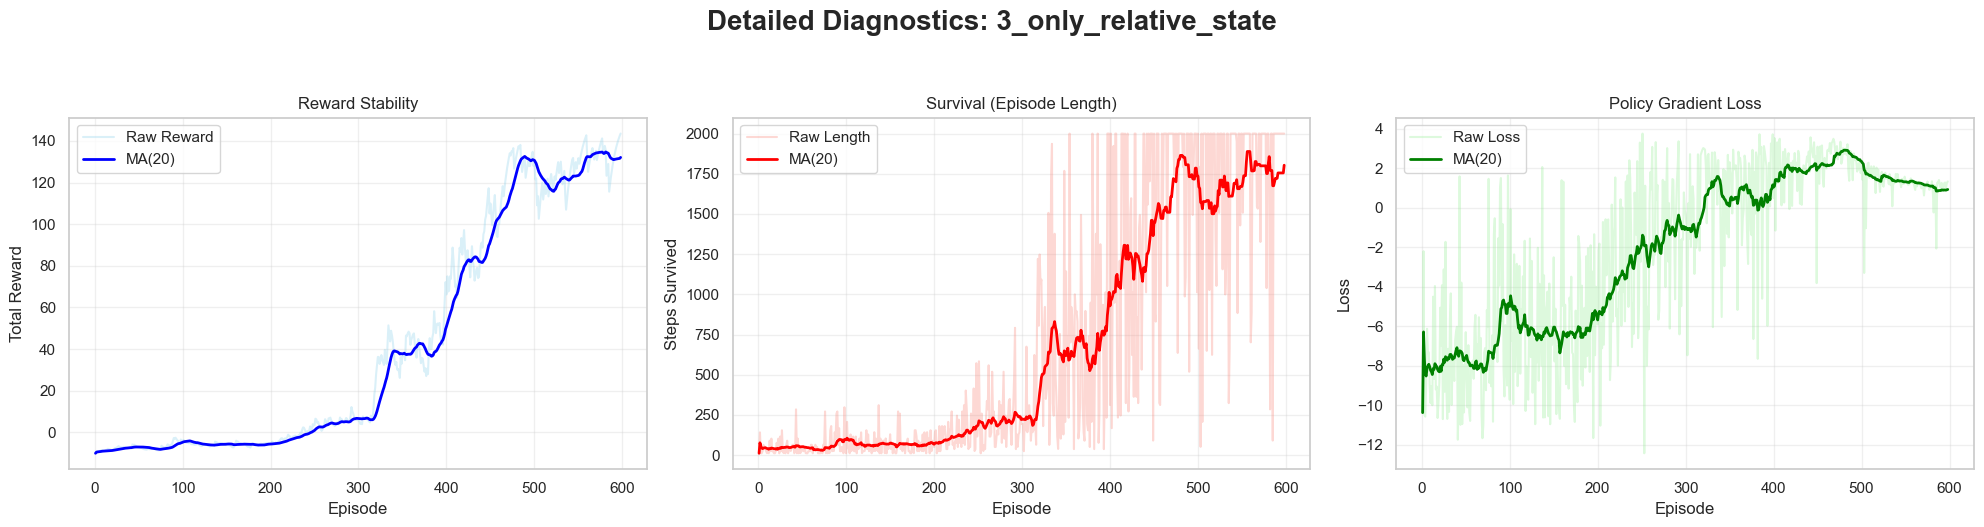

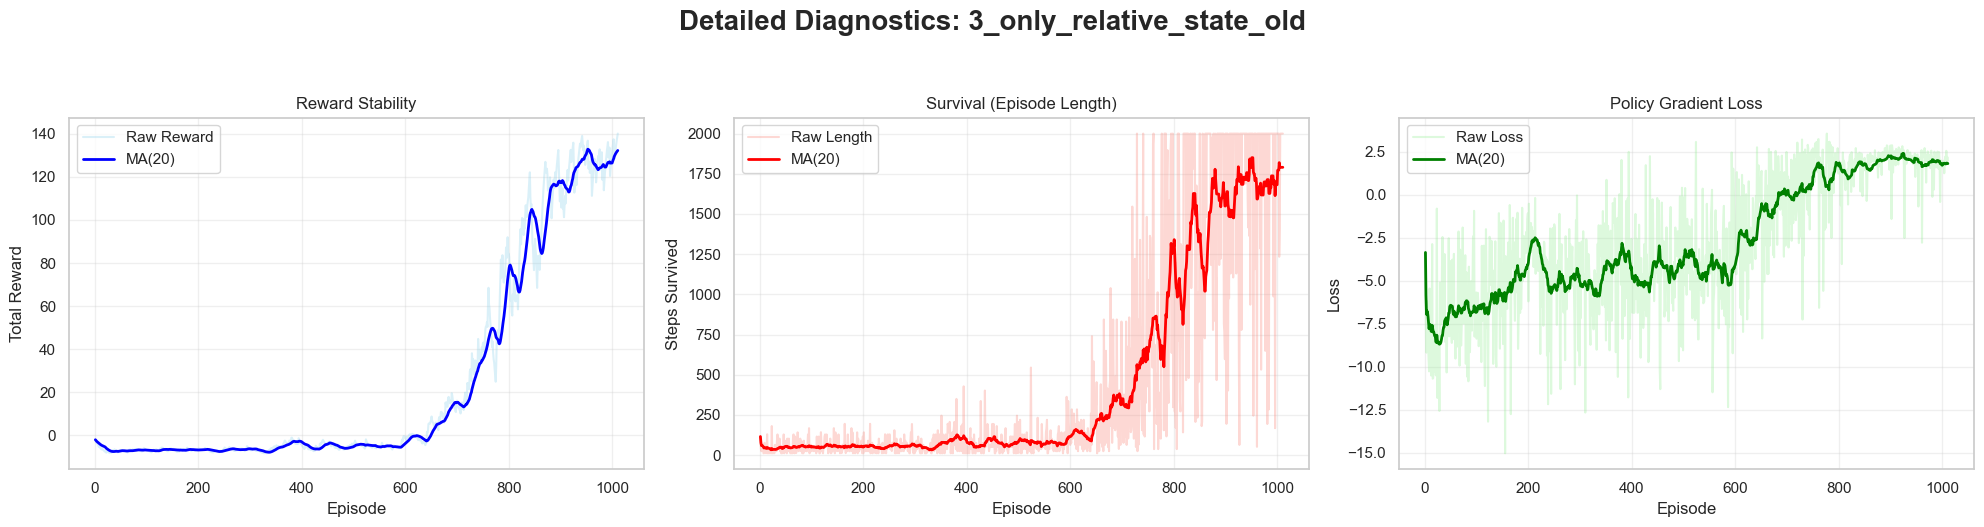

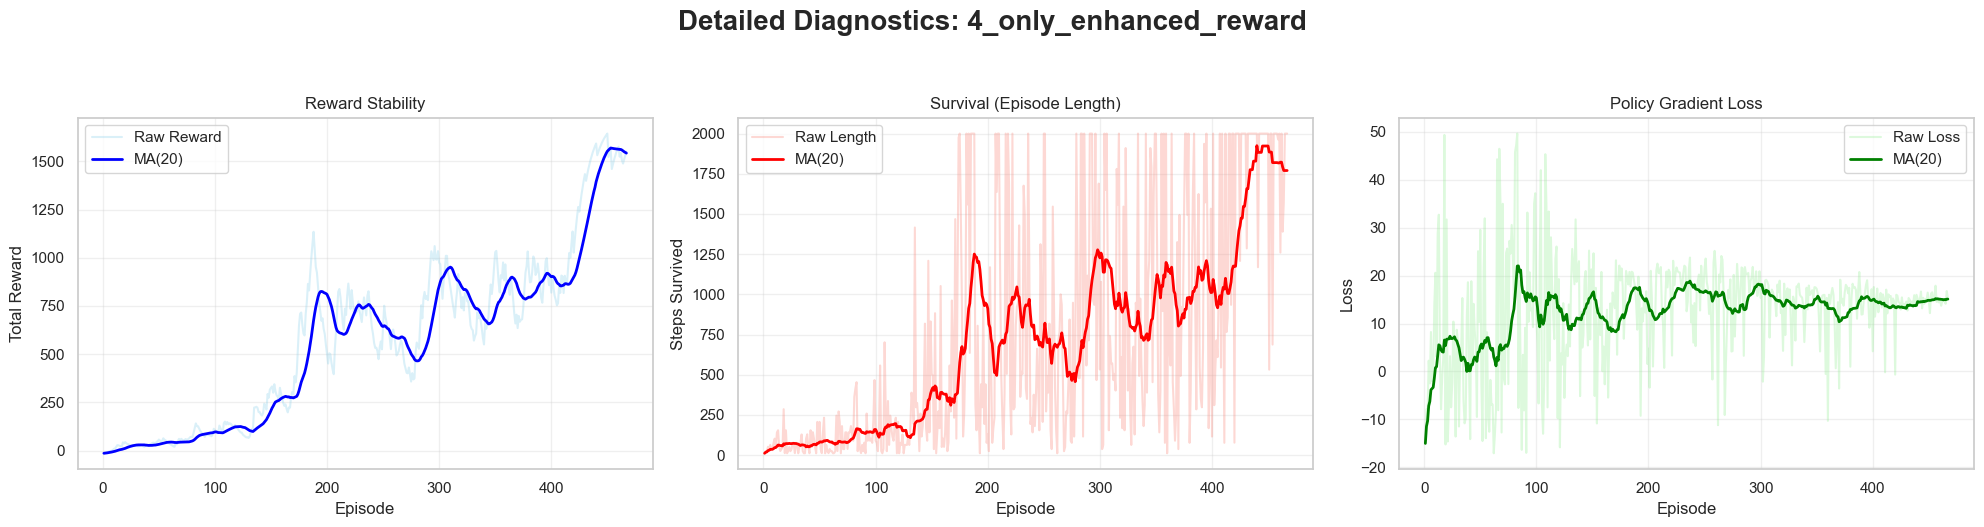

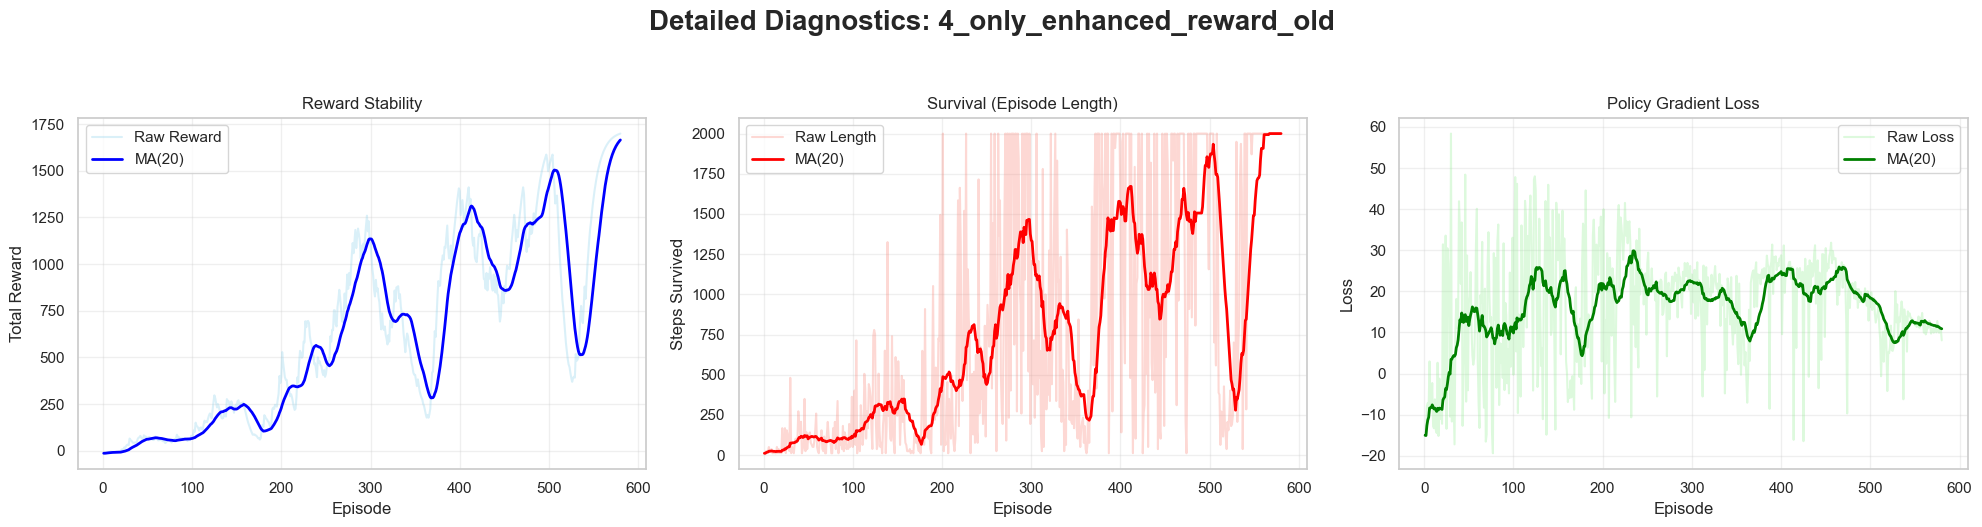

In [5]:
import numpy as np

# Получаем список всех уникальных экспериментов
experiments = df_all['Experiment'].unique()

for exp in experiments:
    # Фильтруем данные для конкретного эксперимента
    df_exp = df_all[df_all['Experiment'] == exp].copy()
    
    # Настройка окна сглаживания
    window = 20
    
    # Создаем фигуру с 3 подграфиками в ряд
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Detailed Diagnostics: {exp}", fontsize=20, fontweight='bold', y=1.05)

    # --- 1) Reward vs Episode ---
    ax = axes[0]
    df_exp["reward_ma"] = df_exp["total_reward"].rolling(window=window, min_periods=1).mean()
    ax.plot(df_exp["episode"], df_exp["total_reward"], color='skyblue', alpha=0.3, label="Raw Reward")
    ax.plot(df_exp["episode"], df_exp["reward_ma"], color='blue', linewidth=2, label=f"MA({window})")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")
    ax.set_title("Reward Stability")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # --- 2) Episode Length vs Episode ---
    ax = axes[1]
    df_exp["len_ma"] = df_exp["episode_length"].rolling(window=window, min_periods=1).mean()
    ax.plot(df_exp["episode"], df_exp["episode_length"], color='salmon', alpha=0.3, label="Raw Length")
    ax.plot(df_exp["episode"], df_exp["len_ma"], color='red', linewidth=2, label=f"MA({window})")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps Survived")
    ax.set_title("Survival (Episode Length)")
    ax.grid(True, alpha=0.3)
    ax.legend()

    # --- 3) Loss vs Episode ---
    ax = axes[2]
    # Убираем аномальные скачки лосса для визуализации, если они есть
    loss_data = df_exp["loss"]
    df_exp["loss_ma"] = loss_data.rolling(window=window, min_periods=1).mean()
    
    ax.plot(df_exp["episode"], loss_data, color='lightgreen', alpha=0.3, label="Raw Loss")
    ax.plot(df_exp["episode"], df_exp["loss_ma"], color='green', linewidth=2, label=f"MA({window})")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Loss")
    ax.set_title("Policy Gradient Loss")
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()